# SQL-Agent

## Overview

In this tutorial, we will build an agent step-by-step that can answer questions

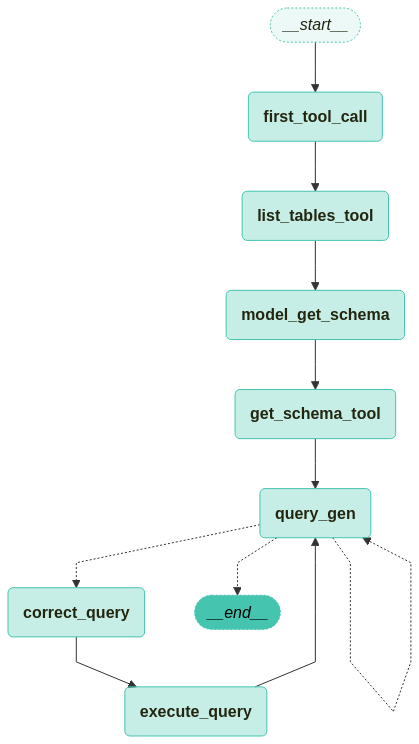

**Key Topics** :
1. **Database** : Set up an SQLite database and load the Chinook sample database.
2. **Utility Functions** : Define utility functions for implementing the agent.
3. **Tool Definitions** : Define tools for interacting with the database.
4. **Workflow Definition** : Define the workflow (graph) for the agent.
5. **Graph Visualization** : Visualize the defined workflow graph.
6. **Agent Execution** : Execute the agent and review the results.
7. **Evaluation** : Evaluate the agent and compare its performance.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Agent for Interacting with SQL Databases](#agent-for-interacting-with-sql-databases)
- [Set Up the Database](#set-up-the-database)
- [Utility Functions](#utility-functions)
- [SQL Query Execution Tools](#sql-query-execution-tools)
- [SQLDatabaseToolkit Tools](#sqldatabasetoolkit-tools)
- [SQL Query Checker](#sql-query-checker)
- [Graph Definition](#graph-definition)
- [Evaluating an SQL Agent Using LangSmith Evaluator](#evaluating-an-sql-agent-using-langsmith-evaluator)

### References
- [SQLite Sample Database](https://www.sqlitetutorial.net/sqlite-sample-database/)
- [Langchain core](https://python.langchain.com/api_reference/core/messages.html#module-langchain_core)
- [SQLDatabaseToolkit](https://python.langchain.com/api_reference/community/agent_toolkits/langchain_community.agent_toolkits.sql.toolkit.SQLDatabaseToolkit.html#langchain_community.agent_toolkits.sql.toolkit.SQLDatabaseToolkit)
- [LangGraph](https://langchain-ai.github.io/langgraph)
- [LangSmith.Client](https://docs.smith.langchain.com/reference/python/client/langsmith.client.Client)
- [LangSmith.evaluation](https://docs.smith.langchain.com/reference/python/evaluation)
---

## Environment Setup


In [ ]:
# import getenv
import os
import getpass
import pyodbc
from sqlalchemy import create_engine
import dotenv
# Load environment variables from .env file
dotenv.load_dotenv()
# Import Azure OpenAI
from langchain_openai import AzureChatOpenAI

from langchain_community.agent_toolkits.sql.base import create_sql_agent
from langchain.agents.agent_types import AgentType
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit

In [ ]:
# Set LLM Model
MODEL_NAME = "gpt-4o"

## Agent for Interacting with SQL Databases


The workflow of an agent that executes SQL queries is as follows:

1. **Understanding the Database Schema** : Retrieve a list of available tables.
2. **Selecting Relevant Tables** : Identify tables related to the question.
3. **Fetching DDL** : Obtain the schema definitions (DDL) of the selected tables.
4. **Generating Queries** : Construct SQL queries based on the question and DDL information.
5. **Query Validation** : Use an LLM to review for common errors and refine the query.
6. **Query Execution and Error Handling** : Execute the query on the database engine and handle errors to ensure successful execution.
7. **Generating Responses** : Provide the final answer based on the query results.

## Set Up the Database

In this tutorial, we will create an Azure SQL DB with the ADVENTUREWORKS sample DB.

In [3]:
# connect to the Azure SQL database

from sqlalchemy import create_engine

connectionString=os.environ["py-connectionString"]
print(connectionString)

# Create a SQLAlchemy engine object for the SQL Server database
db_engine = create_engine(connectionString)

# Create a SQLDatabase object
db = SQLDatabase(db_engine, view_support=True, schema="SalesLT")
print

# test the connection
print(db.dialect)
print(db.get_usable_table_names())
db.run("select convert(varchar(25), getdate(), 120)")

mssql
['Address', 'Customer', 'CustomerAddress', 'Product', 'ProductCategory', 'ProductDescription', 'ProductModel', 'ProductModelProductDescription', 'SalesOrderDetail', 'SalesOrderHeader', 'vGetAllCategories', 'vProductAndDescription', 'vProductModelCatalogDescription']


"[('2025-05-08 15:24:47',)]"

## Utility Functions

Let's define several utility functions to assist in implementing the agent.

In particular, wrap ```ToolNode``` to include error handling and the capability to relay errors back to the agent.

In [4]:
from typing import Any

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


# Error handling function
def handle_tool_error(state) -> dict:
    # Check error information
    error = state.get("error")
    # Check tool information
    tool_calls = state["messages"][-1].tool_calls
    # Wrap with ToolMessage and return
    return {
        "messages": [
            ToolMessage(
                content=f"Here is the error: {repr(error)}\n\nPlease fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


# Create a ToolNode to handle errors and surface them to the agent
def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    # Add fallback behavior for error handling to the ToolNode
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

## SQL Query Execution Tools

To enable the agent to interact with the database, we define several tools.

### Defined Tools:
- ```list_tables_tool``` : Retrieves a list of available tables in the database.
- ```get_schema_tool```  : Fetches the DDL (Data Definition Language) of a table.
- ```db_query_tool```  : Executes queries and retrieves results or returns error messages if the query fails.

### Note:
DDL (Data Definition Language) refers to SQL commands used to define or modify the structure and schema of a database. It includes commands to create, alter, and delete database objects like tables, indexes, and views.

### Key DDL Commands:
- **CREATE** : Creates database objects.
  - Example: CREATE TABLE users (id INT, name VARCHAR(100));
- **ALTER** : Modifies existing database objects.
  - Example: ALTER TABLE users ADD COLUMN email VARCHAR(100);
- **DROP** : Deletes database objects.
  - Example: DROP TABLE users;
---

## SQLDatabaseToolkit Tools

The following tools are provided to interact with the SQL database:

1. ```QuerySQLDatabaseTool```
   - **Function** : Executes SQL queries and returns results.
   - **Input** : Valid SQL query.
   - **Output** : Database results or error messages.
   - **Error Handling** :
     - Rewrites and retries the query if errors occur.
     - Resolves "unknown column" errors by checking table fields using ```sql_db_schema``` .

2. ```InfoSQLDatabaseTool```
   - **Function** : Retrieves table schemas and sample data.
   - **Input** : Comma-separated list of table names.
   - **Usage Example** : table1, table2, table3
   - **Note** : Check table existence using ```sql_db_list_tables``` before using this tool.

3. ```ListSQLDatabaseTool```
   - **Function** : Retrieves a list of tables in the database.

4. ```QuerySQLCheckerTool```
   - **Function** : Validates SQL queries before execution.
   - **Validation Checks** :
     - Use of **NULL** values and **NOT IN** .
     - Suitability of **UNION** vs **UNION ALL** .
     - Correct range settings for **BETWEEN** .
     - Data type consistency.
     - Proper quoting of identifiers.
     - Correct number of function arguments.
     - Proper type casting.
     - Accuracy of join columns.
   - **Features** : Uses a GPT-4o model for validation.


In [5]:
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_openai import AzureChatOpenAI

# Create SQLDatabaseToolkit
toolkit = SQLDatabaseToolkit(db=db, llm = AzureChatOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    openai_api_version=os.getenv("OPENAI_API_VERSION"),
))

# Get the list of available tools from the SQLDatabaseToolkit
tools = toolkit.get_tools()
for tool in tools:
    print(f"class_name : {tool.__class__}")
    print(f"description : {tool.description}")
    print()

class_name : <class 'langchain_community.tools.sql_database.tool.QuerySQLDatabaseTool'>
description : Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

class_name : <class 'langchain_community.tools.sql_database.tool.InfoSQLDatabaseTool'>
description : Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

class_name : <class 'langchain_community.tools.sql_database.tool.ListSQLDatabaseTool'>
description : Input is an empty string, output is a comma-separated list of tables in the database.

class_name : <class 'lang

Below is an example of executing ```list_tables_tool``` and ```get_schema_tool``` .

In [6]:
# Select the tool for listing available tables in the database
list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")

# Select the tool for retrieving the DDL of a specific table
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

# Print the list of all tables in the database
print(f'list_tables :\n`{list_tables_tool.invoke("")}')

print("-" * 100)

# Print the DDL information for the Artist table
print(f'schema :\n{get_schema_tool.invoke("Address")}')

list_tables :
`Address, Customer, CustomerAddress, Product, ProductCategory, ProductDescription, ProductModel, ProductModelProductDescription, SalesOrderDetail, SalesOrderHeader, vGetAllCategories, vProductAndDescription, vProductModelCatalogDescription
----------------------------------------------------------------------------------------------------
schema :

CREATE TABLE [SalesLT].[Address] (
	[AddressID] INTEGER NOT NULL IDENTITY(1,1), 
	[AddressLine1] NVARCHAR(60) COLLATE SQL_Latin1_General_CP1_CI_AS NOT NULL, 
	[AddressLine2] NVARCHAR(60) COLLATE SQL_Latin1_General_CP1_CI_AS NULL, 
	[City] NVARCHAR(30) COLLATE SQL_Latin1_General_CP1_CI_AS NOT NULL, 
	[StateProvince] NVARCHAR(50) COLLATE SQL_Latin1_General_CP1_CI_AS NOT NULL, 
	[CountryRegion] NVARCHAR(50) COLLATE SQL_Latin1_General_CP1_CI_AS NOT NULL, 
	[PostalCode] NVARCHAR(15) COLLATE SQL_Latin1_General_CP1_CI_AS NOT NULL, 
	rowguid UNIQUEIDENTIFIER NOT NULL DEFAULT (newid()), 
	[ModifiedDate] DATETIME NOT NULL DEFAULT (getdat

Next, define ```db_query_tool``` .

In ```db_query_tool``` case, it executes queries against the database and returns the results.

If an error occurs, it returns an error message.

In [7]:
from langchain_core.tools import tool


# Query execution tool
@tool
def db_query_tool(query: str) -> str:
    """
    Run SQL queries against a database and return results
    Returns an error message if the query is incorrect
    If an error is returned, rewrite the query, check, and retry
    """
    # Execute query
    result = db.run_no_throw(query)

    # Error: Return error message if no result
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    # Success: Return the query execution result
    return result

## SQL Query Checker

Next, we will use an LLM to check for common mistakes in SQL queries.

Strictly speaking, this is not a tool, but it will be added as a node in the workflow later.

In [8]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# Define a system message to check SQL queries for common mistakes
query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

# Create the prompt
query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")]
)

# Create the Query Checker chain
query_check = query_check_prompt | AzureChatOpenAI(
    model=MODEL_NAME, temperature=0, api_version="2025-01-01-preview"
).bind_tools([db_query_tool], tool_choice="db_query_tool")

## Graph Definition

Define the workflow for the agent.

The agent first forcefully invokes the ```list_tables_tool``` to retrieve the available tables from the database. After this, it follows the steps mentioned earlier in the tutorial.

In [9]:
from typing import Annotated, Literal

from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.checkpoint.memory import MemorySaver


# Define the agent's state
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


# Create a new graph
workflow = StateGraph(State)


# Add a node for the first tool call
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "initial_tool_call_abc123",
                    }
                ],
            )
        ]
    }


# Define a function to check query accuracy with a model
def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to check that your query is correct before you run it
    """
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}


# Add a node for the first tool call
workflow.add_node("first_tool_call", first_tool_call)

# Add nodes for the first two tools
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_tables_tool])
)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# Add a model node to select relevant tables based on the question and available tables
model_get_schema = AzureChatOpenAI(model=MODEL_NAME, temperature=0, api_version="2025-01-01-preview").bind_tools(
    [get_schema_tool]
)
workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke(state["messages"])],
    },
)

# Add a model node to generate a query based on the question and schema
QUERY_GEN_INSTRUCTION = """You are a SQL expert with a strong attention to detail.

You can define SQL queries, analyze queries results and interpretate query results to response an answer.

Read the messages bellow and identify the user question, table schemas, query statement and query result, or error if they exist.

1. If there's not any query result that make sense to answer the question, create a syntactically correct SQLite query to answer the user question. DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

2. If you create a query, response ONLY the query statement. For example, "SELECT id, name FROM pets;"

3. If a query was already executed, but there was an error. Response with the same error message you found. For example: "Error: Pets table doesn't exist"

4. If a query was already executed successfully interpretate the response and answer the question following this pattern: Answer: <<question answer>>. 
    For example: "Answer: There three cats registered as adopted"
"""

query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", QUERY_GEN_INSTRUCTION), ("placeholder", "{messages}")]
)


query_gen = query_gen_prompt | AzureChatOpenAI(model=MODEL_NAME, temperature=0, api_version="2025-01-01-preview").bind_tools(
    [model_check_query]
)


# Define conditional edges
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    message = state["messages"][-1].content

    # 1) Terminate if the message starts with "Answer:"
    if message.startswith("Answer:"):
        return END

    # 2) Follow existing logic for other cases
    elif message.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"


# Define the query generation node
def query_gen_node(state: State):
    message = query_gen.invoke(state)

    # If the LLM makes incorrect tool calls, return error messages
    tool_messages = []
    message.pretty_print()
    if message.tool_calls:
        for tc in message.tool_calls:
            tool_messages.append(
                ToolMessage(
                    content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                    tool_call_id=tc["id"],
                )
            )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}


# Add the query generation node
workflow.add_node("query_gen", query_gen_node)

# Add a node to check the query with the model before execution
workflow.add_node("correct_query", model_check_query)

# Add a node to execute the query
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))

# Specify edges between nodes
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges(
    "query_gen",
    should_continue,
)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# Compile the workflow into an executable app
app = workflow.compile(checkpointer=MemorySaver())

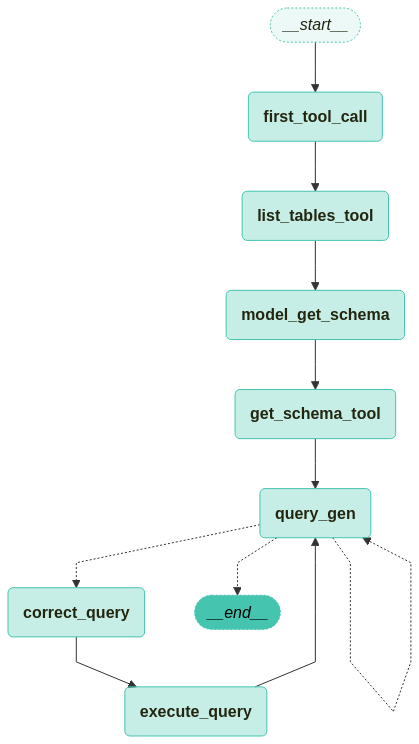

In [10]:
# check the graph workflow
from langchain_opentutorial.graphs import visualize_graph

visualize_graph(app)

### Execution of the Agent

Execute the agent to interact with an SQL database through the entire process.

The agent retrieves information from the database based on user queries, generates and executes SQL queries, and returns the results.

In [11]:
from langchain_core.runnables import RunnableConfig
from langchain_opentutorial.messages import random_uuid, invoke_graph, stream_graph
from langchain_core.messages import HumanMessage
from langgraph.errors import GraphRecursionError


def run_graph(
    message: str, recursive_limit: int = 30, node_names=[], stream: bool = False
):
    # Configure settings (maximum recursion depth, thread ID)
    config = RunnableConfig(
        recursion_limit=recursive_limit, configurable={"thread_id": random_uuid()}
    )

    # Input the user's query
    inputs = {
        "messages": [HumanMessage(content=message)],
    }

    try:
        if stream:
            # Execute the graph with streaming
            stream_graph(app, inputs, config, node_names=node_names)
        else:
            # Execute the graph without streaming
            invoke_graph(app, inputs, config, node_names=node_names)
        # Retrieve and return the output state values
        output = app.get_state(config).values
        return output
    except GraphRecursionError as recursion_error:
        print(f"GraphRecursionError: {recursion_error}")
        # Return output state values even in case of a recursion error
        output = app.get_state(config).values
        return output

In [12]:
output = run_graph(
    "What is the total number of sales orders in the database?",
    stream=True,
)


🔄 Node: first_tool_call 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: list_tables_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Address, Customer, CustomerAddress, Product, ProductCategory, ProductDescription, ProductModel, ProductModelProductDescription, SalesOrderDetail, SalesOrderHeader, vGetAllCategories, vProductAndDescription, vProductModelCatalogDescription
🔄 Node: model_get_schema 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: get_schema_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

CREATE TABLE [SalesLT].[SalesOrderHeader] (
	[SalesOrderID] INTEGER NOT NULL DEFAULT (NEXT VALUE FOR [SalesLT].[SalesOrderNumber]), 
	[RevisionNumber] TINYINT NOT NULL DEFAULT ((0)), 
	[OrderDate] DATETIME NOT NULL DEFAULT (getdate()), 
	[DueDate] DATETIME NOT NULL, 
	[ShipDate] DATETIME NULL, 
	[Status] TINYINT NOT NULL DEFAULT ((1)), 
	[OnlineOrderFlag] BIT NOT NULL DEFAULT ((1)), 
	[SalesOrderNumber] AS ((isnull(N'SO'+CONVERT([nvarchar](23)

In [13]:
output = run_graph(
    "describe the 5 top most requested items, and their quantity?",
    stream=True,
)


🔄 Node: first_tool_call 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: list_tables_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Address, Customer, CustomerAddress, Product, ProductCategory, ProductDescription, ProductModel, ProductModelProductDescription, SalesOrderDetail, SalesOrderHeader, vGetAllCategories, vProductAndDescription, vProductModelCatalogDescription
🔄 Node: model_get_schema 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: get_schema_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

CREATE TABLE [SalesLT].[SalesOrderDetail] (
	[SalesOrderID] INTEGER NOT NULL, 
	[SalesOrderDetailID] INTEGER NOT NULL IDENTITY(1,1), 
	[OrderQty] SMALLINT NOT NULL, 
	[ProductID] INTEGER NOT NULL, 
	[UnitPrice] MONEY NOT NULL, 
	[UnitPriceDiscount] MONEY NOT NULL DEFAULT ((0.0)), 
	[LineTotal] AS ((isnull(([UnitPrice]*((1.0)-[UnitPriceDiscount]))*[OrderQty],(0.0)))) NOT NULL, 
	rowguid UNIQUEIDENTIFIER NOT NULL DEFAULT (newid()), 
	[ModifiedDa

In [14]:
output = run_graph(
    "describe the 5 top most requested items, and their quantity? I do not want product IDs, I want product names",
    stream=True,
)


🔄 Node: first_tool_call 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: list_tables_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Address, Customer, CustomerAddress, Product, ProductCategory, ProductDescription, ProductModel, ProductModelProductDescription, SalesOrderDetail, SalesOrderHeader, vGetAllCategories, vProductAndDescription, vProductModelCatalogDescription
🔄 Node: model_get_schema 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: get_schema_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

CREATE TABLE [SalesLT].[Product] (
	[ProductID] INTEGER NOT NULL IDENTITY(1,1), 
	[Name] NVARCHAR(50) COLLATE SQL_Latin1_General_CP1_CI_AS NOT NULL, 
	[ProductNumber] NVARCHAR(25) COLLATE SQL_Latin1_General_CP1_CI_AS NOT NULL, 
	[Color] NVARCHAR(15) COLLATE SQL_Latin1_General_CP1_CI_AS NULL, 
	[StandardCost] MONEY NOT NULL, 
	[ListPrice] MONEY NOT NULL, 
	[Size] NVARCHAR(5) COLLATE SQL_Latin1_General_CP1_CI_AS NULL, 
	[Weight] DECIMAL(8, 2) NU